# Mercedes-Benz frame in R2

A simple example in 2D.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import frame_whitening as fw
from frame_whitening import plot as fwplt
import seaborn as sns
import os
from tqdm import tqdm

os.chdir(os.path.expanduser("~/frame_whitening"))
print(os.getcwd())

/mnt/home/lduong/frame_whitening


## The Mercedes-Benz frame

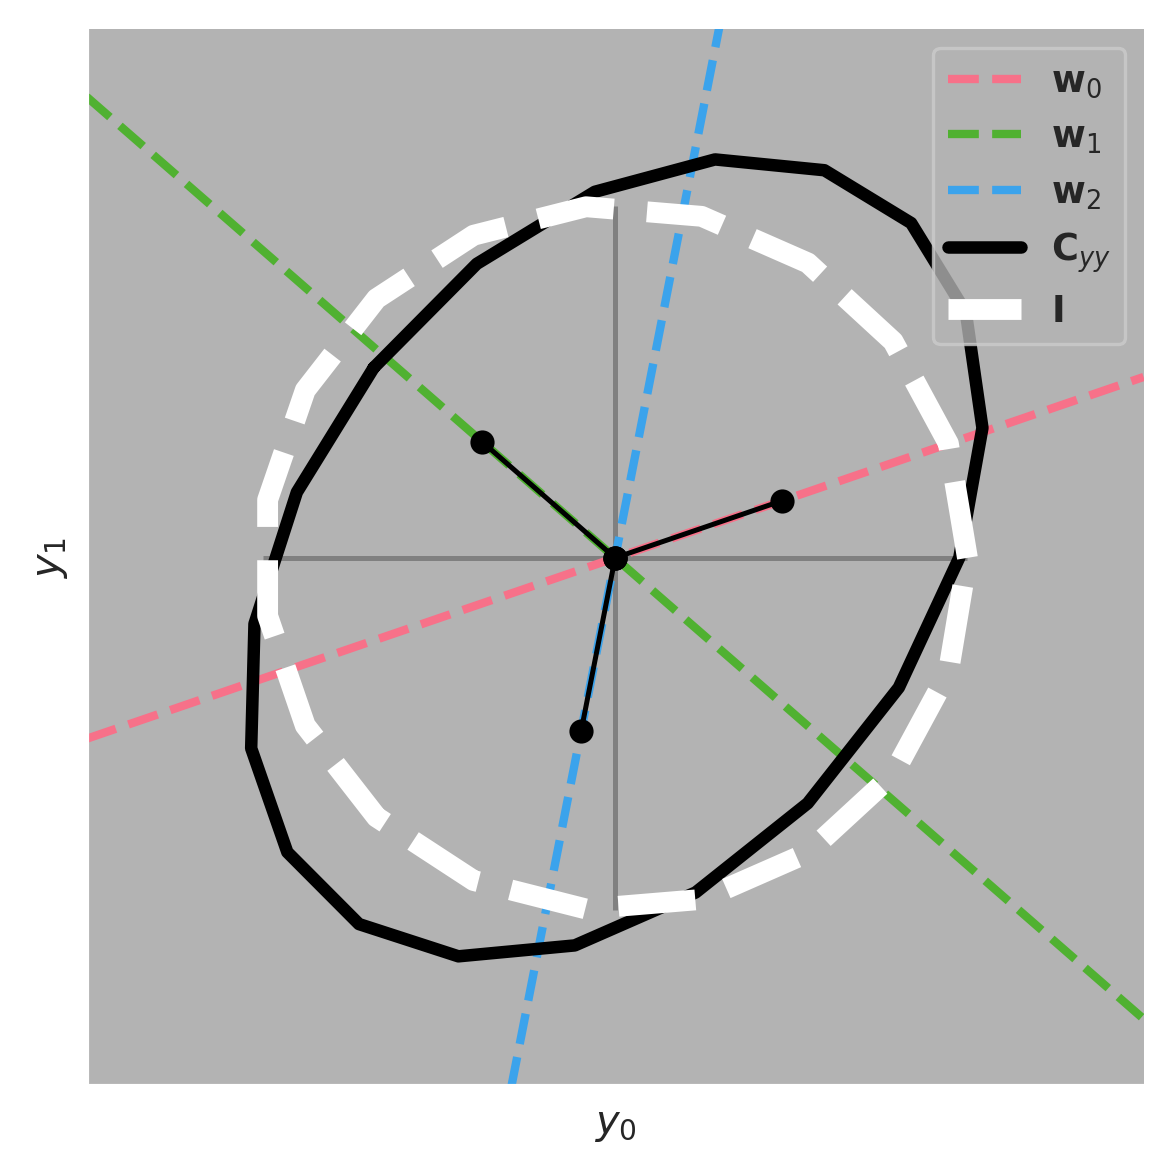

In [5]:
np.random.seed(69)
C, _ = fw.randcov2()
C *= 1.5
I = np.eye(2)
W = fw.get_mercedes_frame(jitter=True)

MAX = 3
with (sns.plotting_context("paper", font_scale=1), 
    sns.axes_style("dark", {"axes.facecolor": "0.7"})):
    fig_frame, ax = plt.subplots(1, 1, dpi=300)
    ax.hlines(0, -2, 2, "grey")
    ax.vlines(0, -2, 2, "grey")

    x = np.linspace(-MAX, MAX, 10)
    cols = sns.color_palette("husl", n_colors=3)
    for i in range(3):
        ax.plot(
            x,
            (W[1, i] / W[0, i]) * x,
            "--",
            color=cols[i],
            linewidth=2,
            label=r"${\bf w}" + f"_{i}$",
        )
    fwplt.plot_frame2d(W, ax=ax, color="k")
    fwplt.plot_ellipse(C, linewidth=3, ax=ax, color="k", label=r'${\bf C}_{yy}$')
    fwplt.plot_ellipse(I, linewidth=5, ax=ax, color="w", linestyle="--", label=r'${\bf I}$')

    ax.axis("square")
    ax.axis((-MAX, MAX, -MAX, MAX))
    ax.set(xlabel="$y_0$", ylabel="$y_1$", xticks=[], yticks=[])

    plt.legend()
    fig_frame.tight_layout()
    sns.despine()


In [ ]:
# fig_frame.savefig("figures/frame_schematic.png", transparent=True, bbox_inches="tight")

## Run simulation

Adapts `g` to a given statistical context defined by Cholesky factor `Lxx`.

In [4]:
def simulate(Lxx, W, batch_size=64, n_batch=1024, lr_g=5e-3, g0=None, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # initialize random set of gains g
    n, k = W.shape
    if g0 is not None:
        g = g0
    else:
        g = np.random.rand(k)

    g_all = []
    error = []
    # run simulation with minibatches
    pbar = tqdm(range(n_batch), leave=False)
    for _ in pbar:
        X = fw.sample_x(Lxx, batch_size)  # draw a sample of x

        # steady-state of y
        y = np.linalg.inv(W @ np.diag(g) @ W.T) @ X

        # compute z and descend gradient of L(g,y) wrt g
        z = W.T @ y
        # dg = 1/batch_size * np.diag(z @ z.T) - np.diag(W @ W.T)
        dg = np.mean(z**2, -1) - 1.0  # more efficient, local gradient
        g = g + lr_g * dg  # gradient descent

        Cyy = np.cov(y)
        error.append(np.linalg.norm(np.eye(n) - Cyy, "fro") ** 2)
        g_all.append(g)
    error = np.array(error)
    g_all = np.stack(g_all, 0)
    return g, g_all, error

Run it.

In [5]:
np.random.seed(420)
num_switches = 2
n, k = 2, 3
batch_size = 128
n_batch = 500
lr_g = 1e-2

all_cov = []
all_g = []
all_g_opt = []
all_x = []
all_y = []
all_cond_x = []
all_cond_y = []
all_errors = []

for i in range(num_switches):

    # run simulation
    Cxx, Lxx = fw.randcov2()
    if i == 0:
        g = np.random.rand(k)
    g, g_all, error = simulate(Lxx, W, batch_size, n_batch, lr_g, g0=g)

    # converged steady-state y samples and Cyy
    X_test = fw.sample_x(Lxx, 1024)
    Y_test = np.linalg.inv(W @ np.diag(g) @ W.T) @ X_test
    Cyy = np.cov(Y_test)

    Csqrt = fw.psd_sqrt(Cxx)
    g_opt = fw.compute_g_opt(Csqrt, W)

    cond_x = np.linalg.cond(Cxx)
    cond_y = np.linalg.cond(Cyy)

    all_cov.append(Cxx)
    all_g.append(g_all)
    all_x.append(X_test)
    all_y.append(Y_test)
    all_g_opt.append(g_opt)

    all_cond_x.append(cond_x)
    all_cond_y.append(cond_y)

    all_errors.append(error)

## Plots

Plot the dynamics.

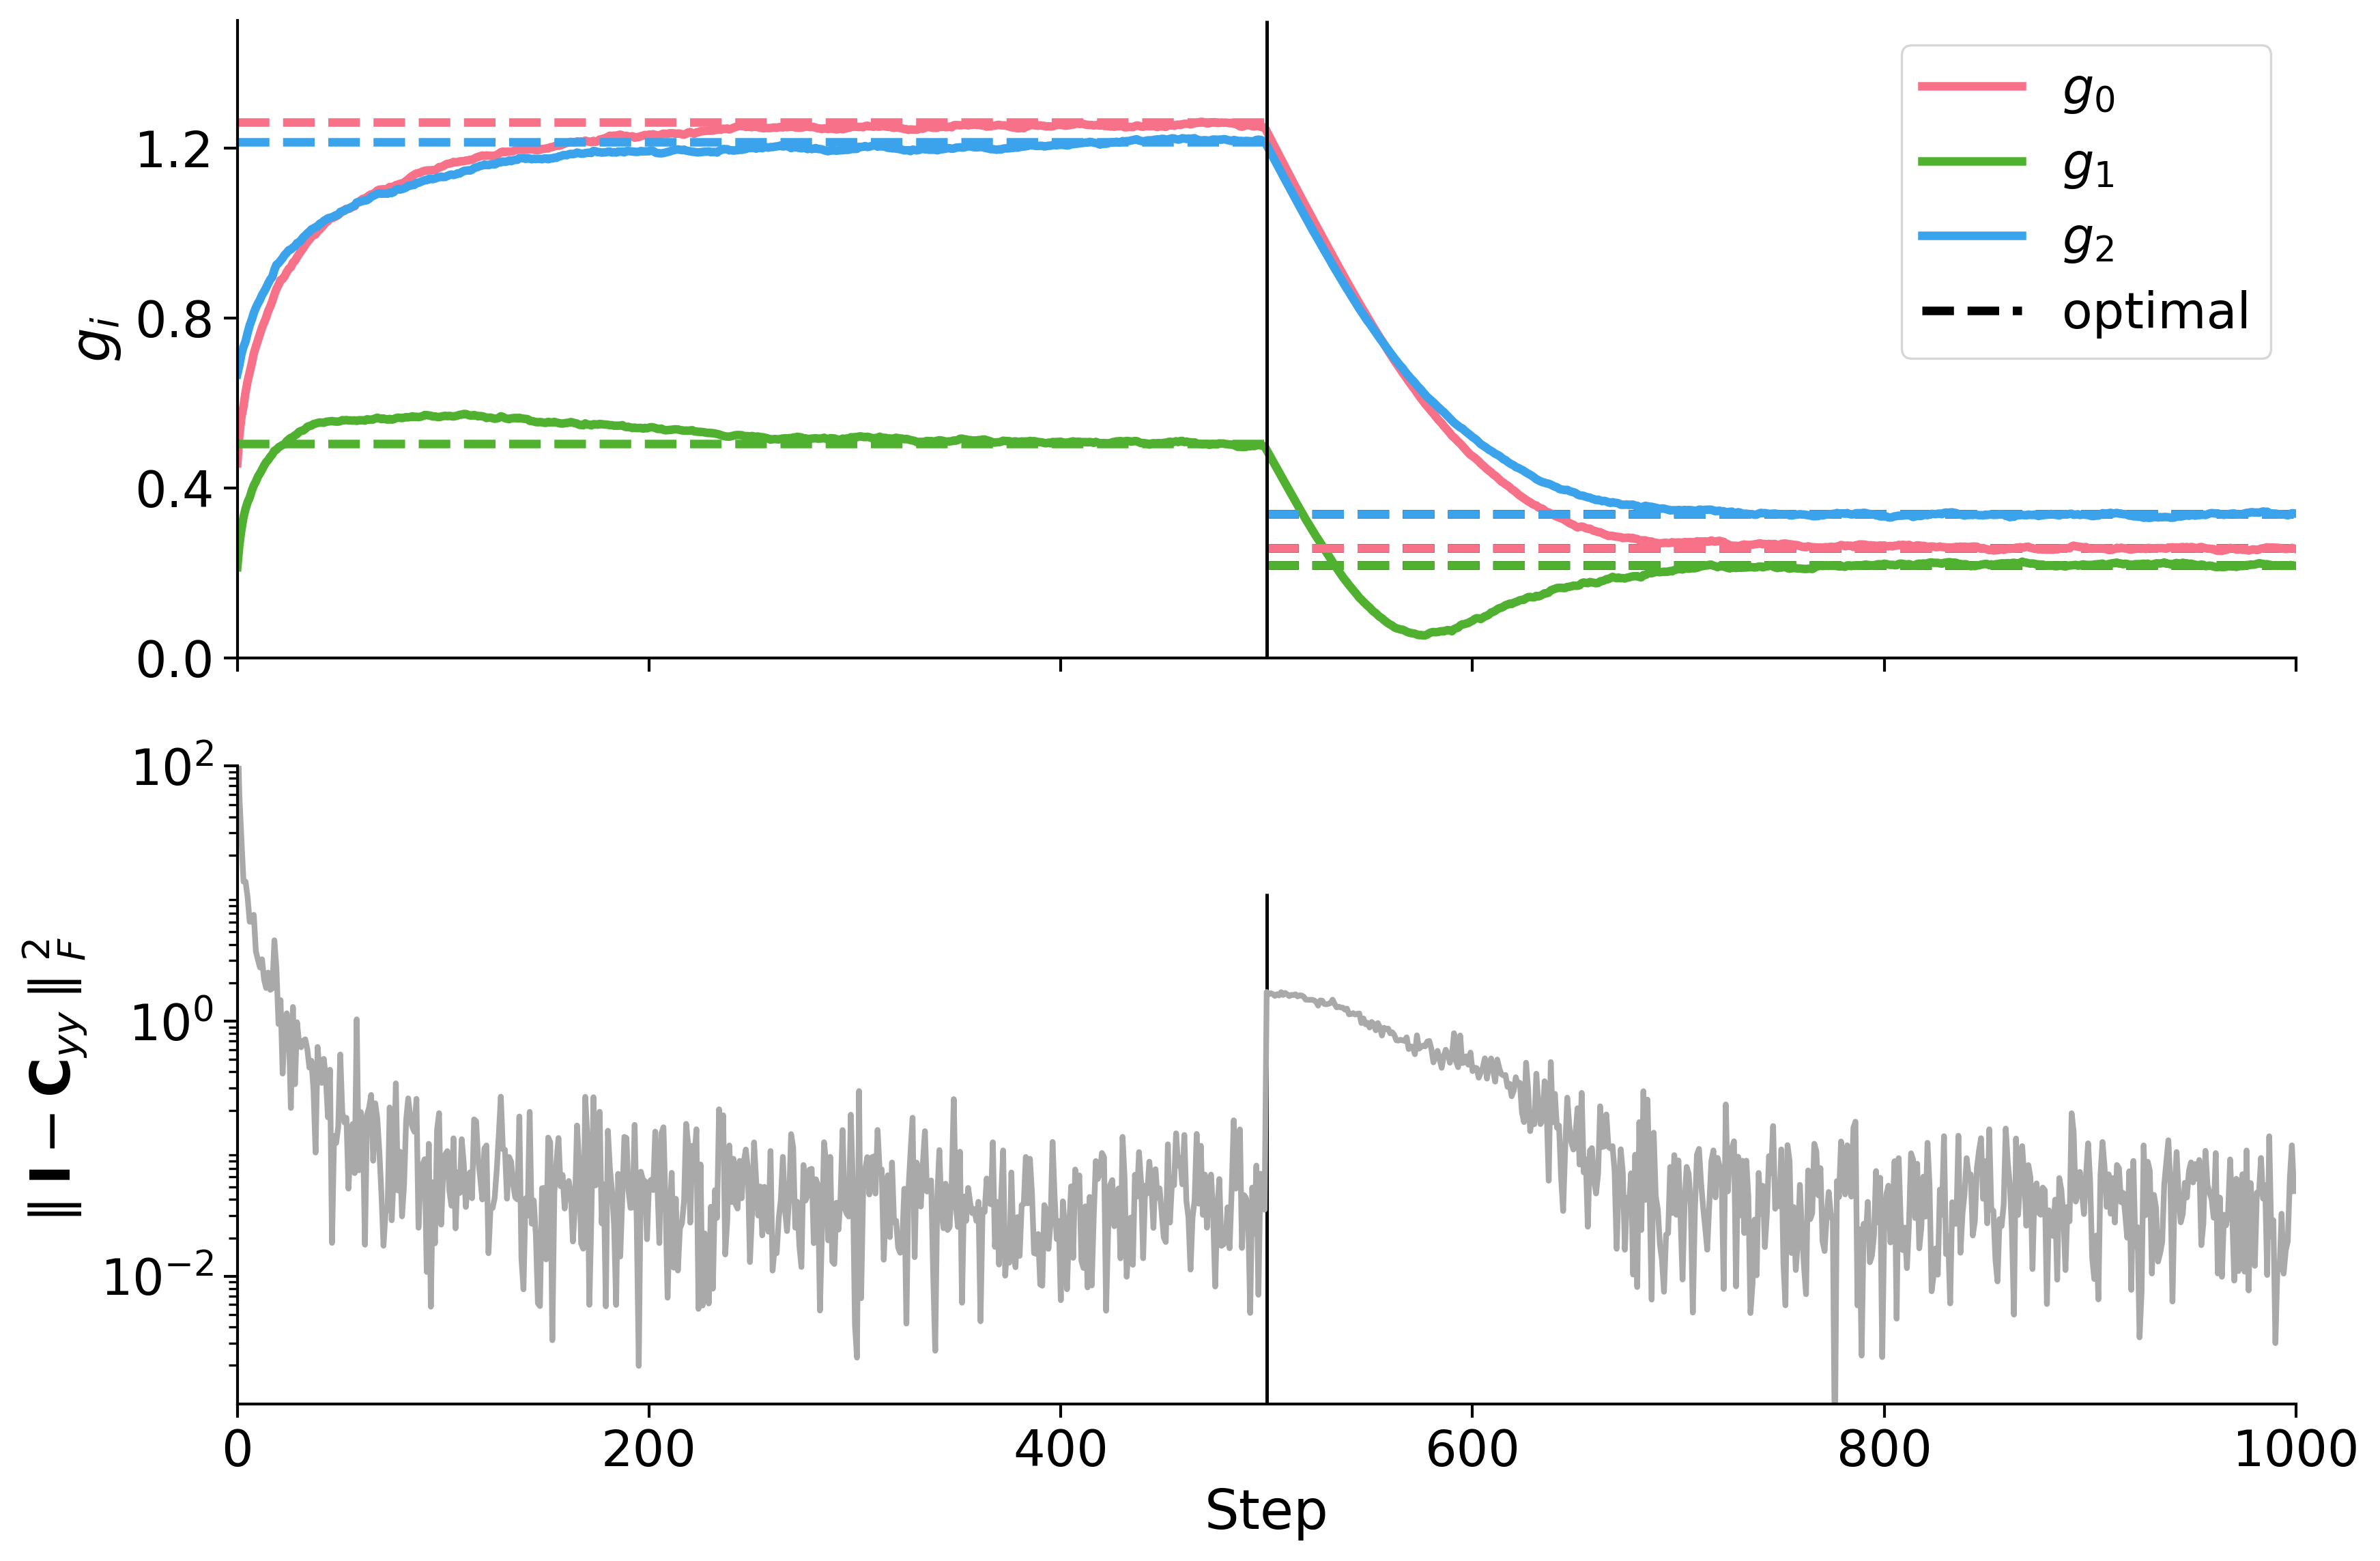

In [16]:
gs = np.concatenate(all_g)
g_opt = np.stack(all_g_opt, 0)
errors = np.concatenate(all_errors)
# fmt: off
with sns.plotting_context("paper", font_scale=2):
    fig_dynamics, ax = plt.subplots(2, 1, figsize=(12, 8), sharex="all", dpi=300)
    [
        ax[0].plot(gs[:, i], label=r"$g_" + f"{i}$", linewidth=3, color=cols[i])
        for i in range(k)
    ]

    for i in range(num_switches):
        ax[0].hlines(
            g_opt[i],
            i * n_batch,
            (i + 1) * n_batch,
            color=cols,
            linestyle="--",
            linewidth=3,
            # label="optimal" if i == 0 else None,
        )
    # dummy line for legend
    ax[0].hlines(
        g_opt[i], i * n_batch, (i + 1) * n_batch, color="k", linestyle="--",
        linewidth=3, label="optimal", zorder=-1)

    ax[0].vlines(np.arange(1, num_switches) * n_batch, 0, 1.5, color="k", linestyle="-")
    ax[1].vlines(
        np.arange(1, num_switches) * n_batch, 1e-3, 10, color="k", linestyle="-"
    )

    ax[0].set(
        ylabel=r"$g_i$",
        xlim=(0, num_switches * n_batch),
        ylim=(0, 1.5),
        yticks=np.arange(0, 1.4, 0.4),
    )

    ax[1].plot(errors, color="darkgrey", linewidth=2)
    ax[1].set(
        ylim=(1e-3, 1e2),
        yscale="log",
        yticks=(1e-2, 1e0, 1e2),
        xlabel="Step",
        ylabel=r"$\parallel {\bf I} - {\bf C}_{yy}  \parallel_F^2$",
    )
    sns.despine()
    ax[0].legend(loc="upper right")
    fig_dynamics.tight_layout()
# fmt: on

Data insets

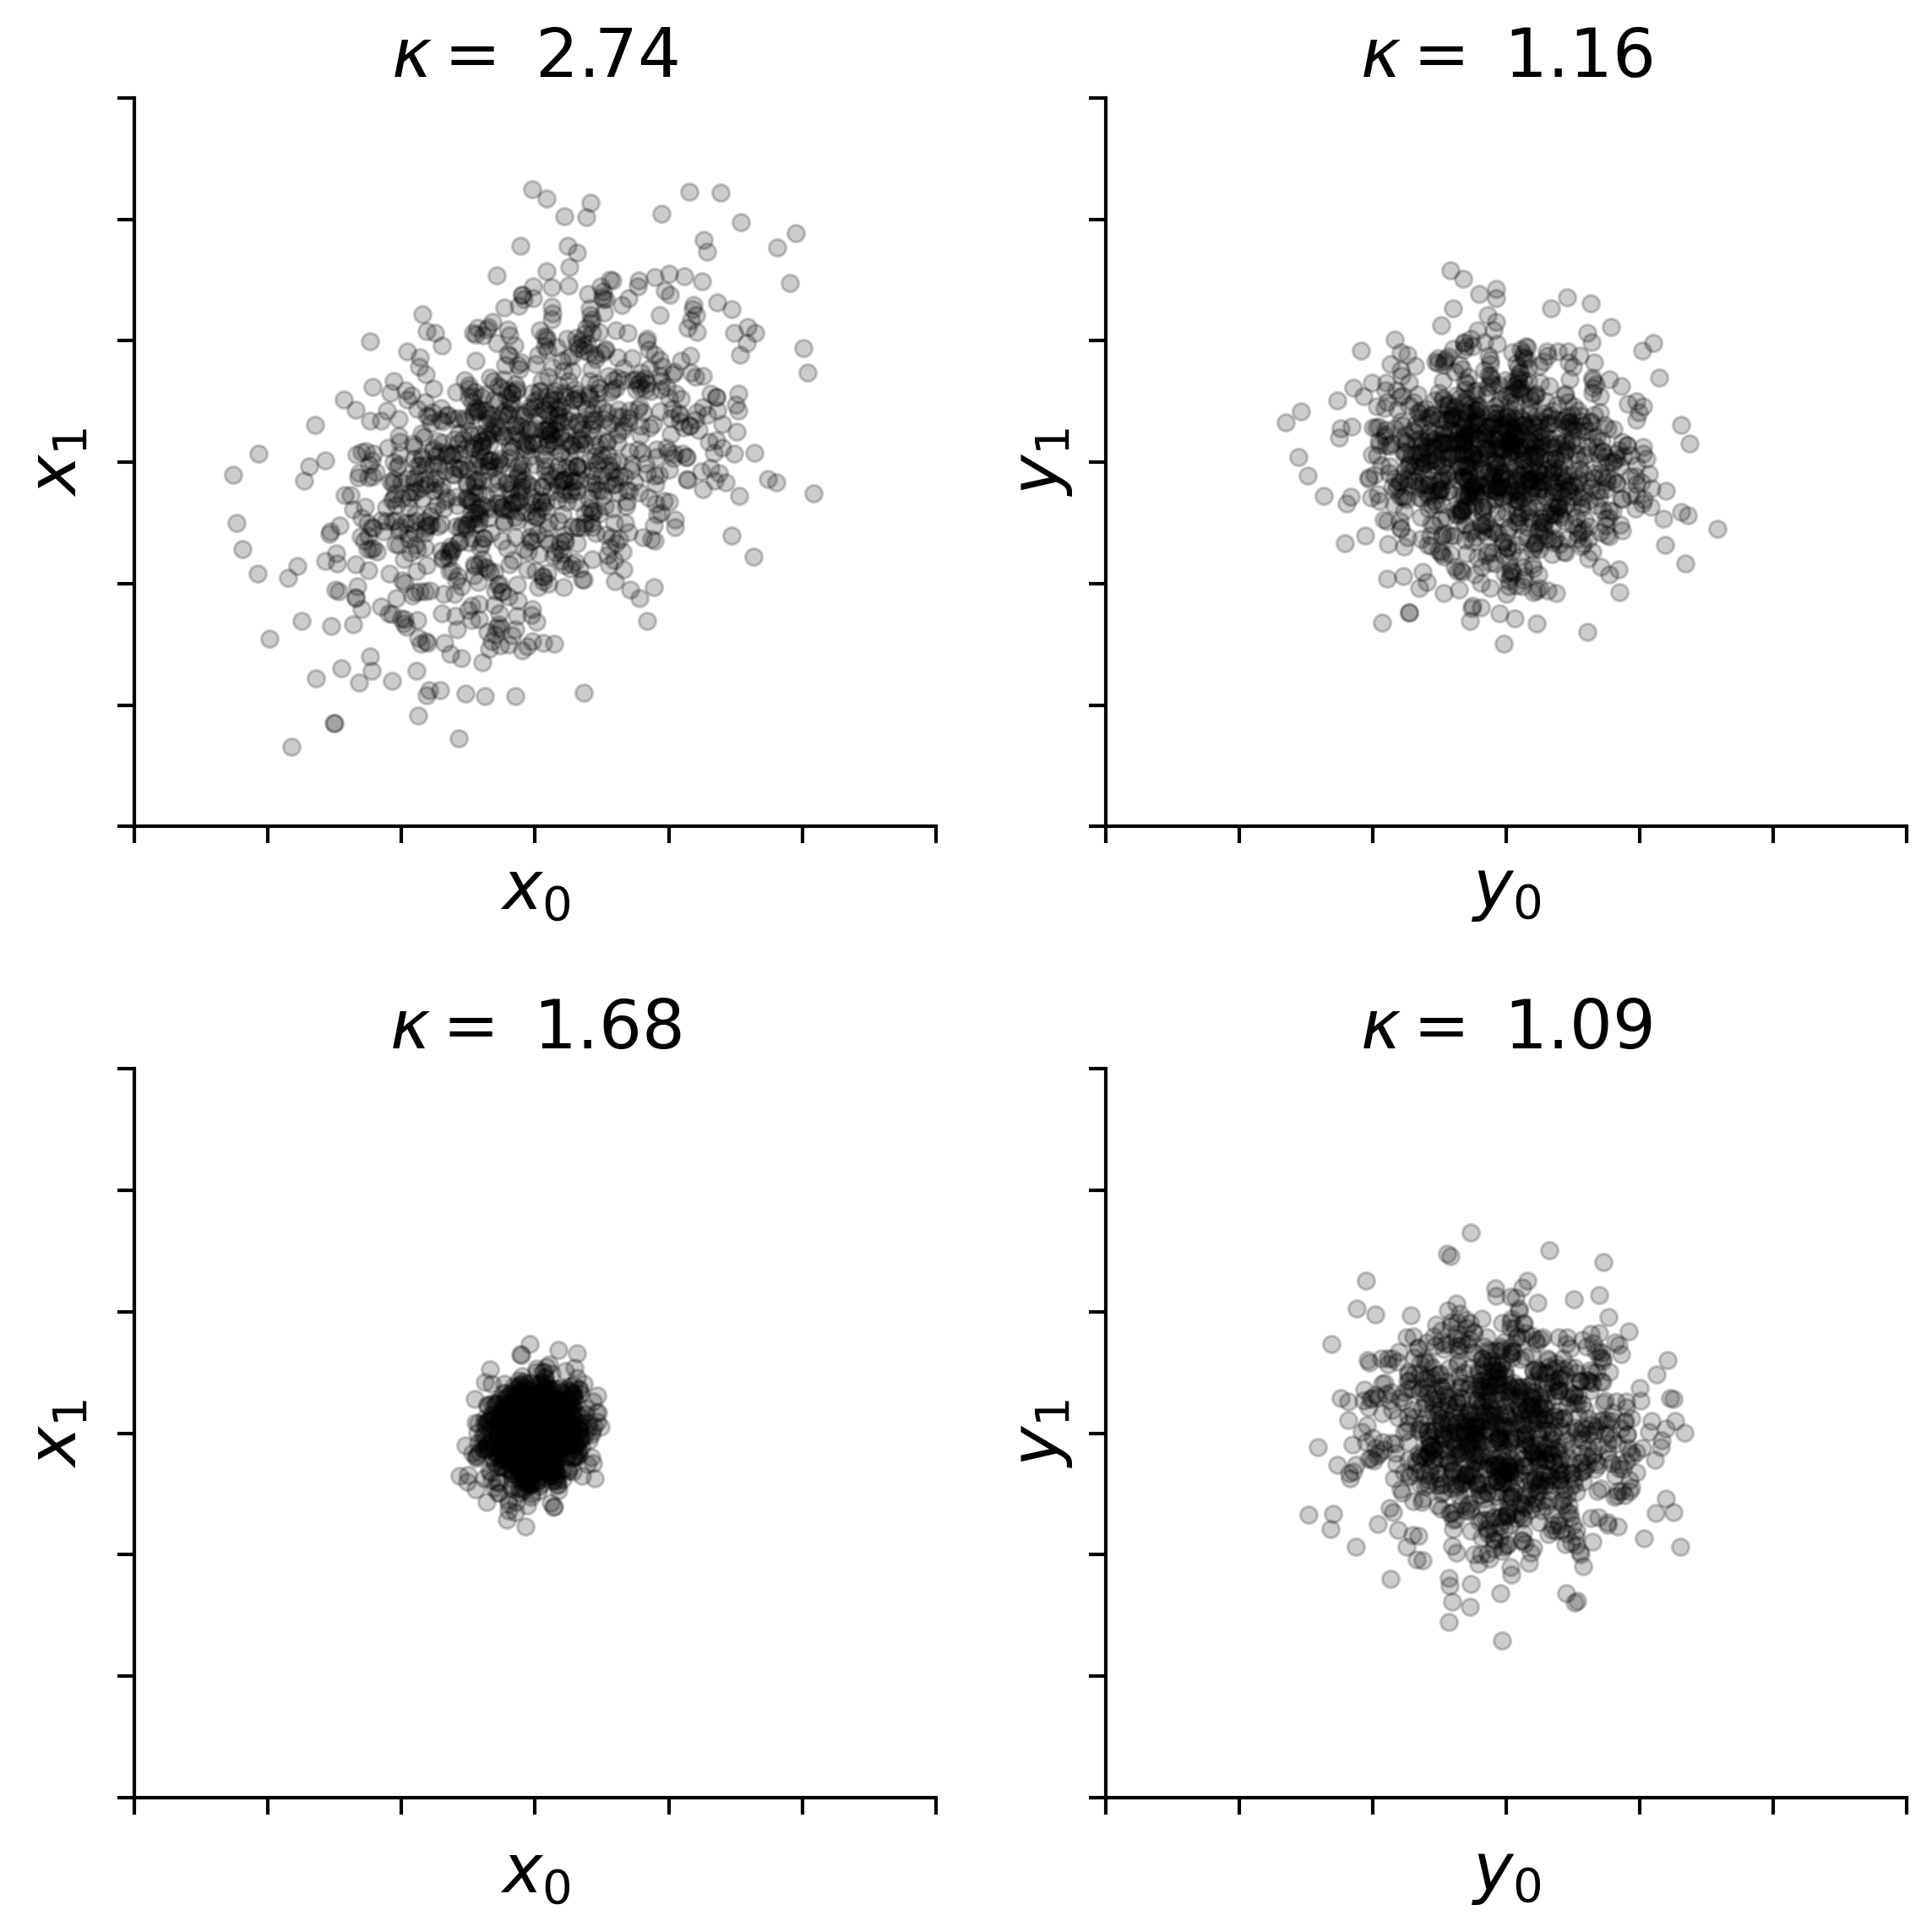

In [11]:
with sns.plotting_context("paper", font_scale=2):
    fig_xy, ax = plt.subplots(
        num_switches,
        2,
        sharex="all",
        sharey="all",
        figsize=(8, 4 * num_switches),
        dpi=300,
    )
    xlim = (-6, 6)
    ylim = xlim
    for i in range(num_switches):
        ax[i, 0].scatter(*all_x[i], color="k", alpha=0.2)
        ax[i, 1].scatter(*all_y[i], color="k", alpha=0.2)
        ax[i, 1].set(xlim=xlim, ylim=ylim)
        ax[i, 0].set(title=f"$\kappa = $ {all_cond_x[i]:.2f}")
        ax[i, 1].set(title=f"$\kappa = $ {all_cond_y[i]:.2f}")
    ax[0, 0].set(
        xlim=xlim,
        ylim=ylim,
        xlabel="$x_0$",
        ylabel="$x_1$",
        xticklabels=[],
        yticklabels=[],
    )
    ax[0, 1].set(xlabel="$y_0$", ylabel="$y_1$")
    ax[1, 0].set(xlabel="$x_0$", ylabel="$x_1$")
    ax[1, 1].set(xlabel="$y_0$", ylabel="$y_1$")
    sns.despine()
    fig_xy.tight_layout()

In [ ]:
fig_dynamics.savefig("figures/fig_dynamics.png", bbox_inches="tight", transparent=True)
fig_xy.savefig("figures/fig_xy.png", bbox_inches="tight", transparent=True)